 # **How Much Your Model's Accuracy is Sensitive to Changes in the Dataset's Structure?**


For a variety of reasons, a machine learning (ML) practitioner may be exposed to dataset shift or loss of instances in his/her dataset. This set of experiments aims to show how intrinsically exposed the practitioner is to variations in accuracy, considering inherent characteristics of the dataset that are not revealed when traditional ML experiments are conducted. A deeper look will be taken into the geometric structure of some datasets, and a method to measure the practitioner's exposure to significant changes in his/her dataset will be proposed, called **accuracy degradation profile** (ADP).

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from holisticai.robustness.metrics import (
    accuracy_degradation_profile,
    accuracy_degradation_factor,
    pre_process_data,
)

from holisticai.robustness.plots import (
                                    plot_2d,
                                    plot_adp_and_adf,
                                    plot_label_and_prediction,
                                    plot_neighborhood,
                                    )


First, create your own 2D classification dataset for experiments:

In [2]:
# Imports
from sklearn.datasets import make_blobs

random_state = 42

# Generate synthetic data using make_blobs with closer centers
center_box = 2.5
X, y = make_blobs(n_samples=100, 
                  centers=2, 
                  n_features=2, 
                  cluster_std=0.8, 
                  center_box=(-center_box, center_box), 
                  random_state=random_state)


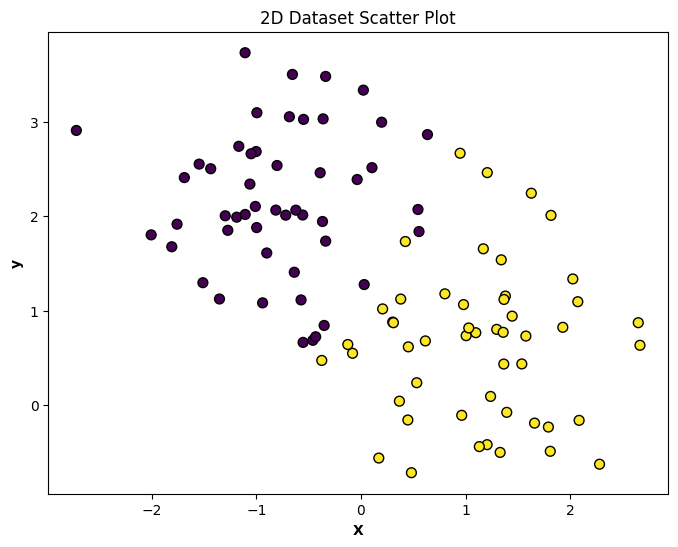

In [3]:
# Plot the 2D classification data
plot_2d(X, y)

Let us perform the usual machine learning pipeline to infer the test accuracy over the **entire** test set using a Decision Tree. You may change the classifier.

In [4]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test, test_indices = pre_process_data(X, y, test_size = 0.3, random_state = random_state)

# Train a classifier over the data
clf = tree.DecisionTreeClassifier(random_state=random_state)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy over the test set
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Accuracy test set: {accuracy_test:.4f}")


Accuracy test set: 0.8667


Let us highlight the test set on the graph. It will be important to manage the possible changes on it.

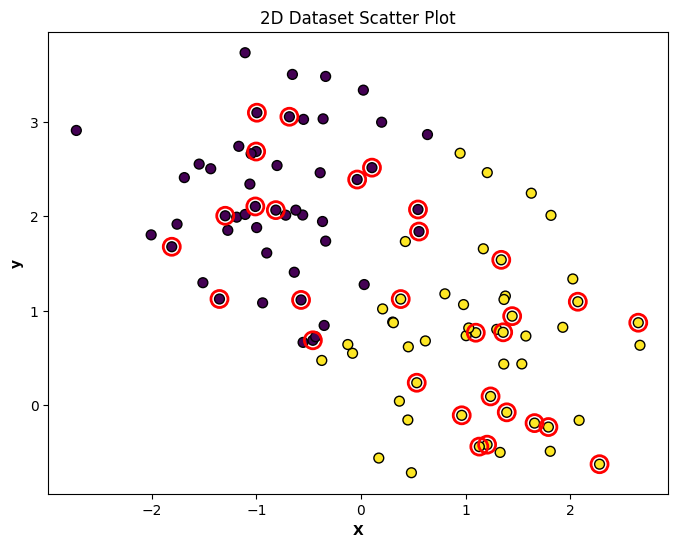

In [5]:
# Highlight the test set on the plot
plot_2d(X, y, highlight_group=test_indices)

Let us maintain just the test set on the graph with a (very!) small index per point for tracking.

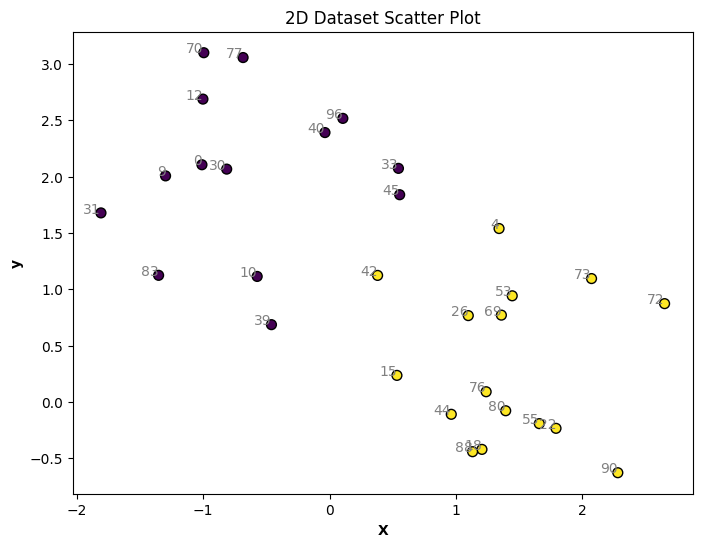

In [6]:
# Plot test set with index
plot_2d(X, y, highlight_group=test_indices, show_just_group=True)

Let us now plot y_test and y_pred together in the same graph. The values of y_pred (shaded circles) are shifted vertically by a small amount to allow better visualization. It is possible to see where the classifier uncorrectedly classified the true labels **by the different collors** between y_test and y_pred.

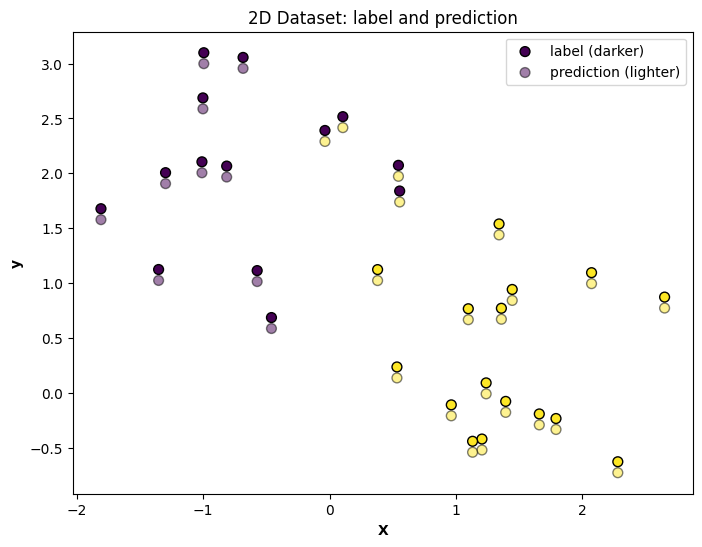

In [7]:
# Plot y_test and y_pred simultaneously
plot_label_and_prediction(X_test, y_test, y_pred, vertical_offset=0.1)

Let us now analyze the neighborhood of a list of selected points in the test set.

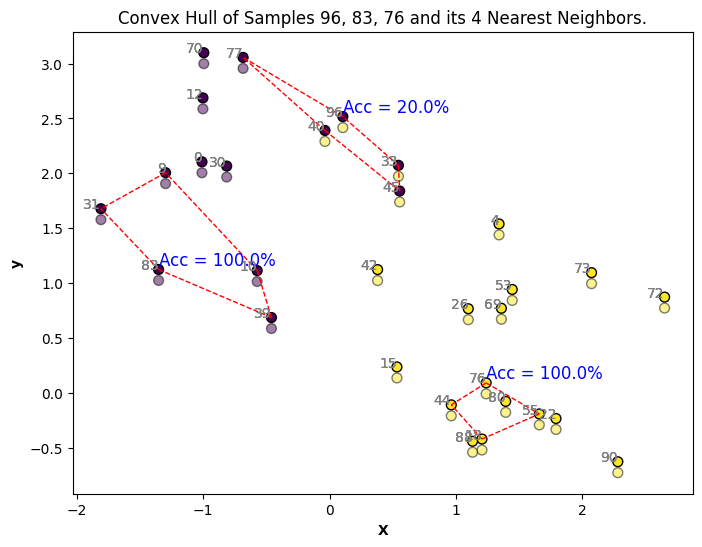

In [8]:
# Choose the size of the neighborhood
n_neighbors = 4

# Choose the points of interest
# Example:
points_of_interest = [96, 83, 76]

# Plot points of interest and its neighborhoods
plot_neighborhood(X_test,
                  y_test,
                  y_pred,
                  n_neighbors,
                  points_of_interest = points_of_interest,
                  vertical_offset = 0.10,
                  indices_show = test_indices)

Check if the accuracies calculated in each convex hull composed of the point of interest and its neighborhood have the same value. Empirical experiments on different synthetic and real datasets have showed that these values were not the same when varying *points_of_interest* or *n_neighbors*. You have probably observed the same. **Why does it happen?** Because the dataset has its own nuances in its topology, which cause the local accuracies, considering only the neighborhoods of the points of interest, to be different.

At this point, we propose the **accuracy degradation profile (ADP)**, a method to evaluate the **robustness** of machine learning models on datasets by iteratively **reducing the test set size** and analyzing the impact on accuracy. ADP points out on each portions (of the reduced dataset) the mean accuracy over each sample considering its neighborhoods falls dows over a defined threshold. APD is clearly understandable by an example.

Let us perform ADP over the selected dataset:

In [9]:
# Perform accuracy degradation profile (ADP)
results = accuracy_degradation_profile(X_test, 
                                    y_test, 
                                    y_pred, 
                                    n_neighbors = 20,
                                    step_size = 0.04,
                                    )
results

/home/andrelfnovaes/holisticai/holisticai/src/holisticai/robustness/metrics/dataset_shift/_accuracy_degradation_profile.py:548: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary_df = pd.concat([results_summary_df, new_row], ignore_index=True)


,size_factor,above_threshold,percent_degradation,average_accuracy,variance_accuracy,degradate,decision
1,0.960000,30,1.000000,0.857143,0.000000,0,OK
2,0.920000,30,1.000000,0.851852,0.000000,0,OK
3,0.880000,30,1.000000,0.846154,0.000000,0,OK
4,0.840000,30,1.000000,0.840000,0.000000,0,OK
5,0.800000,30,1.000000,0.833333,0.000000,0,OK
6,0.760000,4,0.133333,0.824242,0.015452,1,acc degrad!
7,0.720000,12,0.400000,0.834921,0.034192,1,acc degrad!
8,0.680000,12,0.400000,0.840000,0.048990,1,acc degrad!
9,0.640000,14,0.466667,0.843860,0.062987,1,acc degrad!
10,0.600000,14,0.466667,0.850000,0.082589,1,acc degrad!


Understanding the ADP profile matrix, column-by-column:

- **size_factor** is the proportion of the test set that is being considered. If e.g. **size_factor** = 0.95, all samples of the test set are considering just the 95% nearest neighboors for accuracy calculation.

- **above_threshold** is the number of samples with accuracy above the *threshold*. The variable *threshold* is the minimum acceptable accuracy, calculated as *baseline_accuracy* * *threshold_percentual*, with the second term being the threshold percentage for accuracy degradation. If e.g. **above_threshold** = 30, then 30 samples of the test set showed its accuracy (calculated over its neighboorhood) above the minimum acceptable accuracy. Default value for *threshold_percentual*: 0.95.

- **percent_degradation** is the proportion of samples with accuracy above the *threshold*. If e.g. **percent_degradation** = 1.0, then 100% of samples of the test set showed its accuracy (calculated over its neighboorhood) above the minimum acceptable accuracy.

- **decision** is the result of *above_threshold* compared with *above_percentual*, with the second term being the percentage of samples required to be above the threshold to avoid degradation. If *above_threshold* is greater than or equal to *above_percentual*, then there is no accuracy degradation (marked as 'OK').  If *above_threshold* is smaller than *above_percentual*, then there is accuracy degradation (marked as 'acc degrad!'). Default value for *above_percentual*: 0.90.

**Summary**:

Every time you see 'acc degrad!' on the ADP matrix, **watch out** (!!!): *the mean accuracy over the convex hulls (samples and its neighboorhood) are not superior than than the minimum acceptable accuracy*. It may be valuable to look deeper on the topology of the dataset to check what is actually happening with your classifier applied to the reduced dataset. Even if your dataset is multidimensional, you may use dimensionality reduction to look at it in 2D.

The **accuracy degradation factor** (ADF) is the first **size_factor** on which an accuracy degradation occurs. ADF ranges from 0.0 to 1.0. As closer it is to 1.0, **less robust** is the model to dataset shifts considering the ADP methodology. As closer it is to 0.0, **more robust** is the model to dataset shifts considering the ADP methodology.

In [10]:
adf = accuracy_degradation_factor(pd.DataFrame(results.data))
adf

0.76

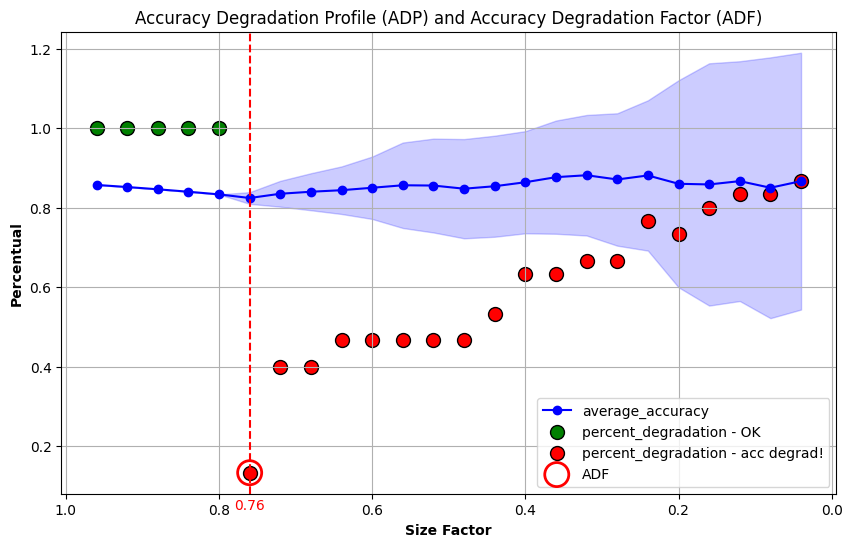

In [11]:
# Plot ADP and ADF
plot_adp_and_adf(results.data)

Let us now apply ADP and ADF to **real datasets:**

(You can import your own dataset)

In [12]:
from holisticai.datasets import load_dataset

# Choose any of the following datasets:
# 'adult'
# 'law_school'
# 'student_multiclass'
# 'us_crime_multiclass'
# 'clinical_records'

# New datasets:
# 'german_credit'
# 'census_kdd'
# 'bank_marketing'
# 'compass'
# 'diabetes'
# 'acsincome'
# 'acspublic'

# Load dataset
dataset = load_dataset('adult')
print(f'Original X shape: {dataset["X"].shape}')
print(f'Original y shape: {dataset["y"].shape}')

# Shrink the dataset
n_rows = 10000 # Select only the first n rows
# n_rows = dataset.data.shape[0] # Select all rows

X = dataset['X'].iloc[:n_rows,:]
y = dataset['y'].iloc[:n_rows]


Original X shape: (45222, 97)
Original y shape: (45222,)


In [13]:
# Split data into training and test sets
X_train, X_test, y_train, y_test, test_indices = pre_process_data(X, y, test_size = 0.3, random_state = random_state)

In [14]:
# Train a classifier over the data
clf = tree.DecisionTreeClassifier(random_state=random_state)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test.values)

# Accuracy over the entire test set
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Accuracy test set: {accuracy_test:.4f}")

Accuracy test set: 0.8047


/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [15]:
# Perform accuracy degradation profile (ADP)
results = accuracy_degradation_profile(X_test, 
                                    y_test, 
                                    y_pred, 
                                    n_neighbors = 50,
                                    step_size = 0.02,
                                    )
results

/home/andrelfnovaes/holisticai/holisticai/src/holisticai/robustness/metrics/dataset_shift/_accuracy_degradation_profile.py:548: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary_df = pd.concat([results_summary_df, new_row], ignore_index=True)


,size_factor,above_threshold,percent_degradation,average_accuracy,variance_accuracy,degradate,decision
1,0.980000,3000,1.000000,0.806296,0.000952,0,OK
2,0.960000,3000,1.000000,0.805053,0.002417,0,OK
3,0.940000,3000,1.000000,0.805116,0.003103,0,OK
4,0.920000,3000,1.000000,0.805020,0.003433,0,OK
5,0.900000,3000,1.000000,0.805475,0.004038,0,OK
6,0.880000,3000,1.000000,0.805749,0.004402,0,OK
7,0.860000,3000,1.000000,0.805959,0.004753,0,OK
8,0.840000,3000,1.000000,0.805800,0.005767,0,OK
9,0.820000,3000,1.000000,0.806078,0.005771,0,OK
10,0.800000,3000,1.000000,0.806070,0.006197,0,OK


In [16]:
# Accuracy over the test set
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Accuracy test set: {accuracy_test:.4f}")

Accuracy test set: 0.8047


# Perform accuracy degradation profile (ADP)

In [17]:
adf = accuracy_degradation_factor(pd.DataFrame(results.data))
adf

0.08

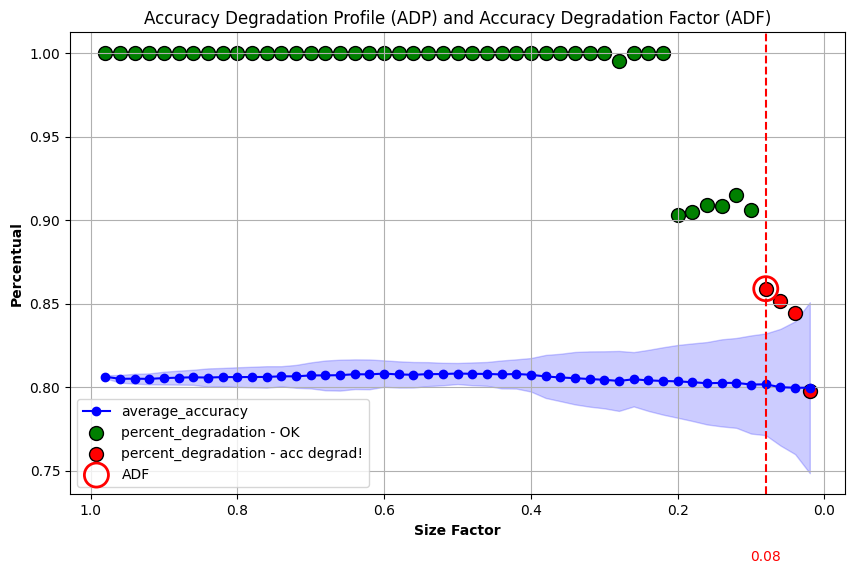

In [18]:
# Plot ADP and ADF
plot_adp_and_adf(results.data)

/home/andrelfnovaes/holisticai/holisticai/src/holisticai/robustness/metrics/dataset_shift/_accuracy_degradation_profile.py:548: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary_df = pd.concat([results_summary_df, new_row], ignore_index=True)
/home/andrelfnovaes/holisticai/holisticai/src/holisticai/robustness/metrics/dataset_shift/_accuracy_degradation_profile.py:548: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary_df = pd.concat([results_summary_df, new_row], ignore_in

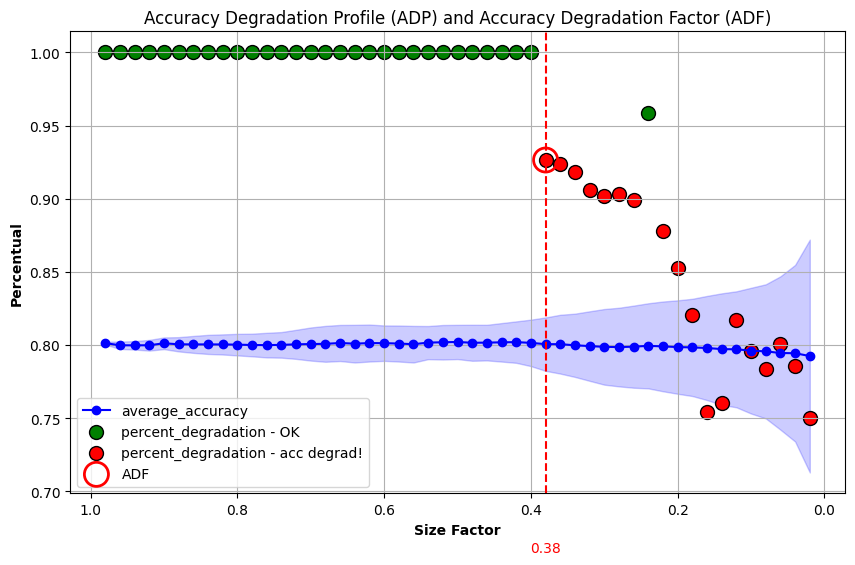

In [19]:
# Perform ADP/ADF with Partitioning
# (compare results with the previous ADP/ADF run to check consistency)

import random

indexes = list(range(len(X_test)))
random.shuffle(indexes)
n_samples = X_test.shape[0]
partition_size = 2000
results_list = []

for i in range(0, n_samples, partition_size):

    X_test_partition = X_test.iloc[indexes[i:i+partition_size]]
    y_test_partition = y_test.iloc[indexes[i:i+partition_size]]
    y_pred_test_partition = y_pred[indexes[i:i+partition_size]]

    results = accuracy_degradation_profile(X_test_partition, 
                                        y_test_partition, 
                                        y_pred_test_partition, 
                                        n_neighbors = 50,
                                        step_size = 0.02,
                                        )
    results_list.append(results.data)


df_results = [x.iloc[:,:-1] for x in results_list]
df_table = sum(df_results) / len(df_results)
df_table["decision"] = df_table["degradate"].apply(lambda x: "acc degrad!" if x > 0 else "OK")
del df_table["degradate"]
# df_table


plot_adp_and_adf(df_table)

You may want to visualize the projections on a 2D plot of your multidimensional dataset.

First, let us choose the 2 features to plot using the *feature importance* criteria.

In [20]:
feat_import = pd.DataFrame(clf.feature_importances_, index = X.columns).sort_values(by=0, ascending=False).rename(columns={0: 'Feature Importance'})
feat_import

,Feature Importance
marital-status_Married-civ-spouse,0.205577
fnlwgt,0.166263
age,0.132859
capital-gain,0.110490
hours-per-week,0.067900
...,...
native-country_Scotland,0.000000
native-country_Thailand,0.000000
native-country_Taiwan,0.000000
native-country_Trinadad&Tobago,0.000000


You may choose among **float** variables:

(float variables may offer a better visualization)

In [21]:
feat_import.loc[X.select_dtypes(include=['float64']).columns.tolist()]

,Feature Importance
age,0.132859
fnlwgt,0.166263
capital-gain,0.110490
capital-loss,0.042101
hours-per-week,0.067900
...,...
native-country_Thailand,0.000000
native-country_Trinadad&Tobago,0.000000
native-country_United-States,0.004688
native-country_Vietnam,0.000000


In [22]:
# # Choose features to plot
# # features_to_plot = ['age', 'capital-gain'] # manually select
# # features_to_plot = feat_import.sample(n=2).index # randomly select
# features_to_plot = feat_import.index[:2] # select the most important ones
# X = X[features_to_plot]


In [23]:
# You can optionally choose the most relevant PCs of PCA as axis to plot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

features_to_plot = ['PC1', 'PC2']
X = pca_df

In [24]:
# Assign data structures
X_train, X_test, y_train, y_test, test_indices = pre_process_data(X, y, test_size = 0.3, random_state = random_state)


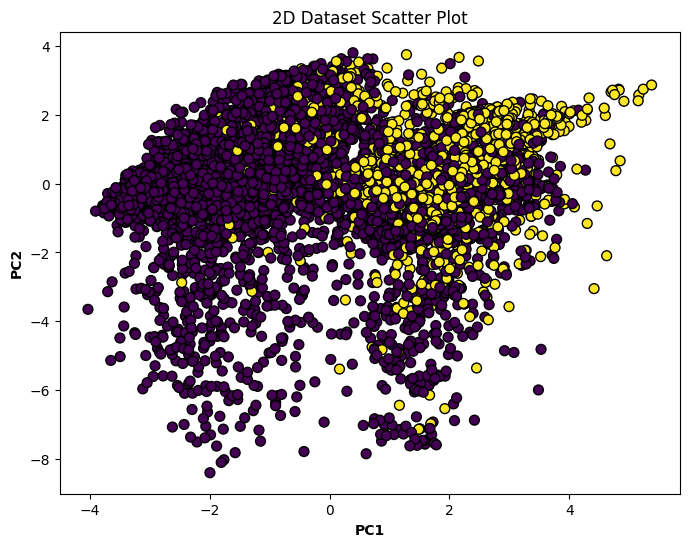

In [25]:
# Plot the 2D classification data
plot_2d(X, y, features_to_plot = features_to_plot)

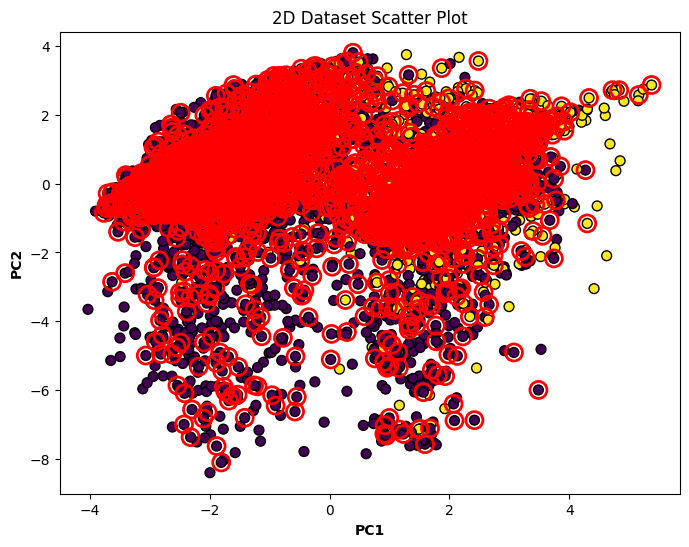

In [26]:
# Highlight the test set on the plot
plot_2d(X, y, highlight_group=test_indices, features_to_plot = features_to_plot)

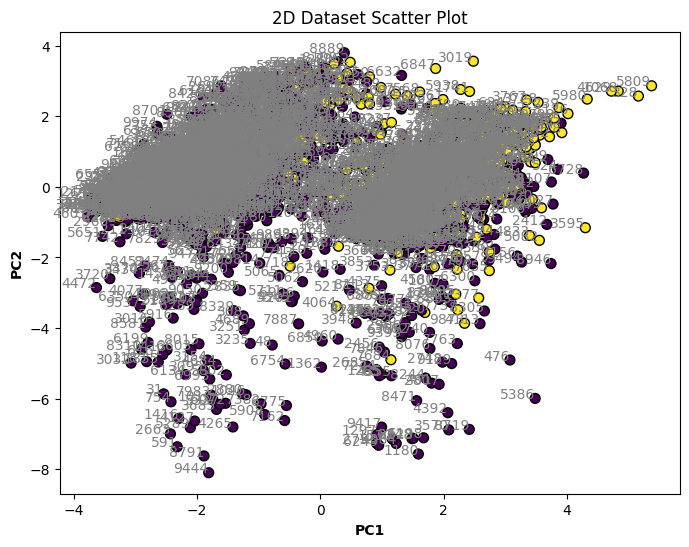

In [27]:
# Plot test set with index
plot_2d(X,
        y,
        highlight_group=test_indices,
        show_just_group=True,
        features_to_plot = features_to_plot)

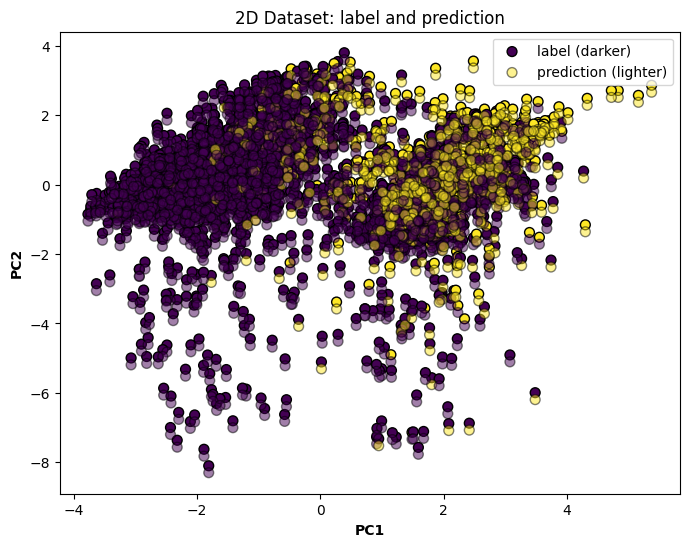

In [28]:
# Plot y_test and y_pred simultaneously
# It maybe necessary to adjust the 'vertical_offset' parameter
plot_label_and_prediction(X_test,
                          y_test,
                          y_pred,
                          vertical_offset=0.2,
                          features_to_plot = features_to_plot)

/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


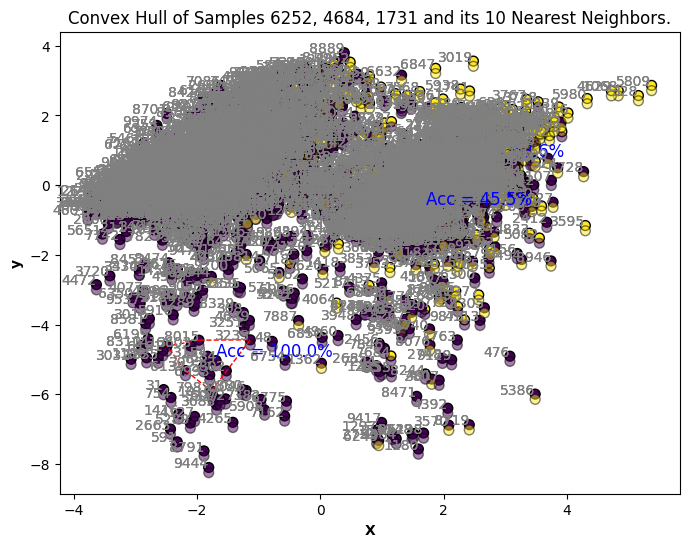

In [29]:
# Choose the size of the neighborhood
n_neighbors = 10

# Choose the points of interest
points_of_interest = test_indices[:3]

# Plot points of interest and its neighborhoods
plot_neighborhood(X_test,
                  y_test,
                  y_pred,
                  n_neighbors,
                  points_of_interest = points_of_interest,
                  vertical_offset = 0.15,
                  indices_show = test_indices)